# ACCEL IMPLEMENTATION

In [1]:
# DANGER: ACCEL does not use a teacher, but a single student that learns from levels selected by a curator, in this impmenetation the curator is a sampler that gives te studemt with a probabilistic manner, the highest regret-based score level, but instaed of discarding the levels during training, it makes small edits to the most diffucult ones, gibing the change to rely on already good but hard leves without the need of a teacher.
# TODO: the start_pos and goal_pos of edited levels are uncorrectly marked, if I mutate the level no

In [31]:
import torch

import numpy as np
import gymnasium as gym

from gymnasium.spaces import Box

from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Goal, Wall
from minigrid.minigrid_env import MiniGridEnv, Grid

from minigrid.wrappers import ImgObsWrapper

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env

from stable_baselines3.common.vec_env import SubprocVecEnv


import matplotlib.pyplot as plt

device = 'cpu'
print(f"Using device: {device}")

# ====================================================
# 1. Custom MiniGrid Environment that returns only the image
#    for SB3's PPO (which expects a Box space).
# ====================================================
class MyCustomGrid(MiniGridEnv):
    """
    Simple MiniGrid environment that places random wall tiles
    according to a config dict, returning only the 'image' observation.
    """

    def __init__(self, config=None, **kwargs):
        if config is None:
            config = {}
        self.config = config

        # Extract parameters from config
        self.width = config.get("width")
        self.height = config.get("height")
        self.num_blocks = config.get("num_blocks")
        self.custom_seed = config.get("seed_val")
        
        
        # Create a random number generator with the custom seed
        self.rng = np.random.default_rng(seed=self.custom_seed)

        grid_size = max(self.width, self.height)

        mission_space = MissionSpace(mission_func=lambda: "get to the green goal square")

        super().__init__(
            grid_size=grid_size,
            max_steps=self.width * self.height * 2, # max_steps is typically 2x the grid size
            see_through_walls=False,
            agent_view_size=5,                      # Size of the agent's view square
            mission_space=mission_space,
            **kwargs
        )

        # Manually define our observation_space as a single Box (the image).
        # By default, MiniGrid's image shape is (view_size, view_size, 3) if using partial obs,
        # or (height, width, 3) if using full-grid observation. We'll do full-grid here:
        # We'll define (self.height, self.width, 3) as the shape.
        # In practice, "image" shape can vary if partial observations are used.
        self.observation_space = Box(
            low=0,
            high=255,
            shape=(self.agent_view_size, self.agent_view_size, 3),
            dtype=np.uint8
        )

    def _gen_grid(self, width, height):
        """
        Generate the grid layout for a new episode.
        We use self.width and self.height from config, even though the underlying
        MiniGrid environment might use grid_size for some of its operations.
        """    
        
        # Create an empty grid of the "true" width x height from config
        self.grid = Grid(self.width, self.height)
        # Surround the grid with walls
        self.grid.wall_rect(0, 0, self.width, self.height)
        
        # Place random walls inside using the custom seed. Only place a wall if the cell is empty.
        for _ in range(self.num_blocks):
            r = self.rng.integers(1, self.height - 1)
            c = self.rng.integers(1, self.width - 1)
            if self.grid.get(c, r) is None: #and (c, r) != self.config["start_pos"] and (c, r) != self.config["goal_pos"]:
                self.put_obj(Wall(), c, r)
        
        # Place the goal object in a random position not occupied by any wall
        """if self.config["goal_pos"] is None:"""
        while True:
            r = self.rng.integers(1, self.height - 1)
            c = self.rng.integers(1, self.width - 1)
            if self.grid.get(c, r) is None: # and (c, r) != self.config["start_pos"]:
                self.put_obj(Goal(), c, r)
                self.config["goal_pos"] = (c, r)
                break
        """elif self.config["goal_pos"] is not None:
            c, r = self.config["goal_pos"]
            self.put_obj(Goal(), c, r)"""

        # Place the agent in a random position not occupied by any wall and not on the goal
        
        """if self.config["start_pos"] is None:"""
        while True:
            r = self.rng.integers(1, self.height - 1)
            c = self.rng.integers(1, self.width - 1)
            if self.grid.get(c, r) is None: # and (c, r) != self.config["goal_pos"]:
                self.place_agent(top=(c, r), rand_dir=True)
                self.config["start_pos"] = (c, r)
                break  
        """elif self.config["start_pos"] is not None:
            c, r = self.config["start_pos"]
            self.place_agent(top=(c, r), rand_dir=True)"""
     

    def reset(self, **kwargs):
        """
        Override reset to ensure we only return the 'image' array
        instead of a dict with 'image' and 'mission'.
        """
        obs, info = super().reset(**kwargs)
        obs = self._convert_obs(obs)
        return obs, info

    def step(self, action):
        """
        Same for step: override to convert the dict observation into an image only.
        """
        obs, reward, done, truncated, info = super().step(action)
        obs = self._convert_obs(obs)
        return obs, reward, done, truncated, info

    def _convert_obs(self, original_obs):
        """
        original_obs is typically {'image':..., 'mission':...}.
        We'll just return original_obs['image'] to get a Box(low=0,high=255) shape.
        """
        return original_obs["image"]
        #return np.transpose(original_obs["image"], (2, 0, 1))
    
    def update_config(self, new_config):
        self.config = new_config
        self.width = new_config.get("width")
        self.height = new_config.get("height")
        self.num_blocks = new_config.get("num_blocks")
        self.custom_seed = new_config.get("seed_val")
        self.rng = np.random.default_rng(seed=self.custom_seed)
        self.reset()



def random_config(grid_size, num_blocks=None):
    max_blocks = int(((grid_size - 1) * (grid_size - 1)) / 2)
    
    if num_blocks is None:
        num_blocks = np.random.randint(1, max_blocks)
    else:
        num_blocks = min(num_blocks, max_blocks)
    
    return {
        "width": grid_size,
        "height": grid_size,
        "num_blocks": num_blocks,
        "start_pos": None,
        "goal_pos": None,
        "edited": False,
        "seed_val": np.random.randint(0, 999999),
    }
    
# Modify an existing configuration, adding randomness.
def edit_config(old_config):
    max_blocks = int(((old_config["width"] - 1) * (old_config["height"] - 1)) / 2)
    
    new_config = dict(old_config)
    
    # Randomly change the number of blocks
    new_number_blocks = old_config["num_blocks"] + np.random.choice([1])
    
    # Ensure the number of blocks is within bounds
    new_config["num_blocks"] = max(1, min(new_number_blocks, max_blocks))    
    
    # Mark the config as edited
    new_config["edited"] = True
    
    return new_config



# ====================================================
# 2. Simple “level buffer” 
# ====================================================
# class to memorize generated levels and score
class LevelBuffer: 
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []  # will store (config_dict, score)

    def add(self, config, score):
        self.data.append((config, score))
        if len(self.data) > self.max_size:
            self.data.sort(key=lambda x: x[1], reverse=True)
            self.data = self.data[: self.max_size]
            #it memorize only the highest score for each level

    def sample_config(self): 
        # Samples a level from the buffer, weighting the probabilities 
        # based on the scores.
        if len(self.data) == 0:
            return None
        scores = [item[1] for item in self.data]
        total = sum(scores)
        if total <= 1e-9:
            # fallback to uniform
            idx = np.random.randint(len(self.data))
            return self.data[idx][0]
        probs = [s / total for s in scores]
        idx = np.random.choice(len(self.data), p=probs)
        return self.data[idx][0]

# ====================================================
# 3. Utility Functions
# ====================================================

# Calculate regret using Generalized Advantage Estimation (GAE) with Stable-Baselines3's PPO model.
# PLR approximates regret using a score function such as the positive value loss.
def calculate_regret_gae(env, model, max_steps, gamma, lam):
    """
    Calculate regret using Generalized Advantage Estimation (GAE)
    with Stable-Baselines3's PPO model.
    """
    obs, _ = env.reset()
    regrets = []
    rewards = []
    dones = []
    values = []

    for t in range(max_steps):
        # Add batch dimension to the observation tensor
        obs_tensor = torch.as_tensor(obs).float().unsqueeze(0).to(device)
        
        # Use the model's policy to get the value and action.
        # For actions, model.predict handles single observations well.
        action, _ = model.predict(obs, deterministic=True)
        
        # Compute the value from the policy.
        value_t = model.policy.predict_values(obs_tensor).item()
        values.append(value_t)
        
        # Perform the step in the environment
        obs, reward, done, truncated, _ = env.step(action)
        rewards.append(reward)
        dones.append(done)

        if done or truncated:
            break

    # Add value of the terminal state (0 if done/truncated)
    if done or truncated:
        terminal_value = 0.0
    else:
        terminal_obs_tensor = torch.as_tensor(obs).float().unsqueeze(0).to(device)
        terminal_value = model.policy.predict_values(terminal_obs_tensor).item()
    values.append(terminal_value)

    # Compute TD-errors and GAE-like regret score
    for t in range(len(rewards)):
        delta_t = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        discounted_error = (gamma * lam) ** t * delta_t
        regrets.append(max(0, discounted_error))

    # Return the maximum positive regret score (or 0 if empty)
    return max(regrets) if regrets else 0.0


def initialize_ppo(env, learning_rate=1e-4):
    return PPO(
        "MlpPolicy",                    # Multi-layer perceptron policy
        env,                            # environment to learn from
        verbose=0,                      # Display training output
        n_steps=256,                    # Number of steps to run for each environment per update
        batch_size=64,                  # Minibatch size for each gradient update
        learning_rate=learning_rate,    # Learning rate for optimizer
        device=device                   # Use GPU if available
    )

def print_level_from_config(config):
    env = MyCustomGrid(config, render_mode='rgb_array')
    env.reset()
    full_level_image = env.render()  # This should return an RGB image of the full grid

    plt.figure(figsize=(4, 4))
    plt.imshow(full_level_image)
    plt.title("Level Configuration: " + str(config))
    plt.axis("off")
    plt.show()
    
# Use vectorized environment
def create_vectorized_env(config, n_envs=4):
    """
    Create a vectorized environment with n parallel environments.
    """
    return make_vec_env(lambda: MyCustomGrid(config), n_envs=n_envs)



def main_accel(total_iterations, replay_prob, train_steps, level_buffer_size,
               initial_fill_size, grid_size, n_envs, edit_levels, regret_threshold,
               easy_start, parallel_regret):
    
    # Create a level buffer, a personal class to store levels and scores
    level_buffer = LevelBuffer(max_size=level_buffer_size)
    
    # Generate a random configuration {width, height, num_blocks, start_pos, goal_pos}
    dummy_config = random_config(grid_size)
    
    # Create a vectorized environment, so a wrapper for MyCustomGrid that allows interconnection 
    # between gymnasium and stable-baselines3 to train the model in a vectorized way, since we
    # are using DummyVecEnv, it is not true parallelism
    vectorized_env = create_vectorized_env(dummy_config, n_envs=n_envs)

    # Initialize PPO with vectorized environment
    print("Initializing student model PPO...")
    student_model = initialize_ppo(vectorized_env)

    # ====================================================
    # Initial buffer fill
    # ====================================================
    
    print(f"Populating buffer with {initial_fill_size} initial levels with regret > {regret_threshold}...")
    while len(level_buffer.data) < initial_fill_size:
        
        if easy_start:
            cfg = random_config(grid_size, num_blocks=2)
        else:
            cfg = random_config(grid_size)
        
        for monitor in vectorized_env.envs:
            monitor.env.update_config(cfg)
        
        student_model.learn(total_timesteps=train_steps)
        
        regret = calculate_regret_gae(MyCustomGrid(cfg), student_model, max_steps=1000, gamma=0.99, lam=0.95)

        # Skip levels with low regret
        if regret < regret_threshold: continue

        level_buffer.add(cfg, regret)

    # ====================================================
    # Main ACCEL loop
    # ====================================================
    
    iteration_regrets = []
    iteration, skipped = 0, 0
    
    print("\nMain training loop...")
    while iteration < total_iterations + skipped:
        print(f"\n=== ITERATION {iteration + 1}/{total_iterations + skipped} SKIPPED: {skipped} ===")
        
        iteration += 1
        
        # Decide whether to replay or generate a new level
        use_replay = np.random.rand() < replay_prob

        if not use_replay or len(level_buffer.data) == 0:
            # Create a new random level
            cfg = random_config(grid_size)
            print("Generated new random level:", cfg)
        else:
            # Sample a level from the buffer
            cfg = level_buffer.sample_config()
            print("Sampled level from buffer:", cfg)
            
        # Update the vectorized environment with the selected config and train the model
        for monitor in vectorized_env.envs:
            monitor.env.update_config(cfg)
        
        student_model.learn(total_timesteps=train_steps)

        if use_replay and edit_levels:
            # Edit the level and calculate regret
            cfg = edit_config(cfg)
            print("Edited level to:", cfg)

        regret = calculate_regret_gae(MyCustomGrid(cfg), student_model, max_steps=1000, gamma=0.99, lam=0.95)
        
        if regret <= regret_threshold:
            print(f"Regret for current level is {regret:.5f} <= threshold {regret_threshold}. Skipping...")
            skipped += 1
            continue

        print(f"Regret for current level: {regret}")
        level_buffer.add(cfg, regret)
        iteration_regrets.append(regret)
        
    
    # Plot and display the progress
    plt.figure(figsize=(8, 4))
    plt.plot(iteration_regrets, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Regret")
    plt.title("Regret Progress during ACCEL Training")
    plt.grid(True)
    plt.show()
    
    print("\nDone. Final buffer size:", len(level_buffer.data))
    print("Top-5 hardest levels (config, regret):")
    level_buffer.data.sort(key=lambda x: x[1], reverse=True)
    for i, (cfg, sc) in enumerate(level_buffer.data[:5]):
        print(f"{i + 1}. regret={sc:.5f}, config={cfg}")
        #print_level_from_config(cfg)
        
    print("Top-5 easiest levels (config, regret):")
    level_buffer.data.sort(key=lambda x: x[1])
    for i, (cfg, sc) in enumerate(level_buffer.data[:5]):
        print(f"{i + 1}. regret={sc:.5f}, config={cfg}")
        #print_level_from_config(cfg)
    
    return student_model

Using device: cpu


# TRAIN

In [ ]:
# use pprun to profile and list by cumulative time
config = {
        "grid_size": 5,
        
        "total_iterations": 1000,
        "train_steps": 500,

        "replay_prob": 0.8,            # Probability of replaying a level and editing it vs. generating a new one
        "level_buffer_size": 128,       # Maximum number of levels to store in the buffer
        "initial_fill_size": 64,       # Number of levels to pre-fill the buffer with
        "regret_threshold": 0.00,      # Minimum regret threshold to consider a level for the buffer
        
        "n_envs": 1,                   # Number of parallel environments to use for training
        
        "edit_levels": True,           # Whether to edit levels during training i.e. ACCEL or PLR
        "easy_start": True,            # Whether to fill the buffer with easy levels first i.e. minimum number of blocks
        
        "parallel_regret": False       # Whether to use parallel GAE-based regret calculation
    }



'''config["edit_levels"] = False
config["easy_start"] = False
print(f"Running PLR with config: {config}")
model_plr = main_accel(**config)

# Save the model
model_plr.save("plr_model")

print("\n\n============================================\n\n")

config["edit_levels"] = True
config["easy_start"] = False
print(f"Running ACCEL with config: {config}")
model_accel = main_accel(**config)

# Save the model
model_accel.save("accel_model")

print("\n\n============================================\n\n")
'''

config["edit_levels"] = True
config["easy_start"] = True
print(f"Running ACCEL with easy start with config: {config}")
model_accel_easy = main_accel(**config)

# Save the model
model_accel_easy.save(f"accel_model_easy_{config['grid_size']}x{config['grid_size']}")

Running ACCEL with easy start with config: {'grid_size': 5, 'total_iterations': 1000, 'train_steps': 500, 'replay_prob': 0.8, 'level_buffer_size': 128, 'initial_fill_size': 64, 'regret_threshold': 0.0, 'n_envs': 1, 'edit_levels': True, 'easy_start': True, 'parallel_regret': False}
Initializing student model PPO...
Populating buffer with 64 initial levels with regret > 0.0...

Main training loop...

=== ITERATION 1/1000 SKIPPED: 0 ===
Sampled level from buffer: {'width': 5, 'height': 5, 'num_blocks': 2, 'start_pos': (1, 2), 'goal_pos': (3, 1), 'edited': False, 'seed_val': 533573}
Edited level to: {'width': 5, 'height': 5, 'num_blocks': 3, 'start_pos': (3, 2), 'goal_pos': (1, 2), 'edited': True, 'seed_val': 533573}
Regret for current level is 0.00000 <= threshold 0.0. Skipping...

=== ITERATION 2/1001 SKIPPED: 1 ===
Generated new random level: {'width': 5, 'height': 5, 'num_blocks': 4, 'start_pos': None, 'goal_pos': None, 'edited': False, 'seed_val': 146289}
Regret for current level: 0.6

# EVALUATION

c:\Users\Emanuele\miniconda3\envs\accel_env_cuda\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Evaluating level 1 with 11 blocks for model ACCEL-EasyStart...


Evaluating level 2 with 22 blocks for model ACCEL-EasyStart...
Evaluating level 3 with 33 blocks for model ACCEL-EasyStart...

Model: ACCEL-EasyStart
Level 1 - Complexity 11: 0.69
Level 2 - Complexity 22: 0.35
Level 3 - Complexity 33: 0.50



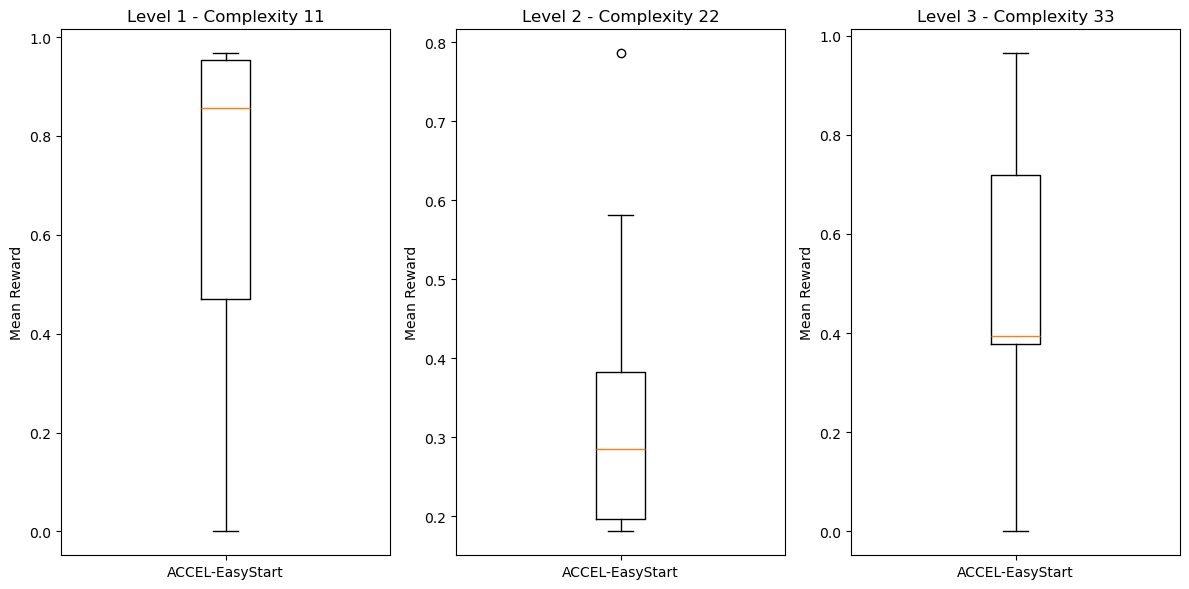

In [26]:
# Load the models
model_plr = PPO.load("plr_model")
model_accel = PPO.load("accel_model")
model_accel_easy = PPO.load("accel_model_easy")

# Inseert the models in a dictionary
models = {'PLR': model_plr, 'ACCEL': model_accel, 'ACCEL-EasyStart': model_accel_easy}
models = {'ACCEL-EasyStart': model_accel_easy}

# Generate n levels difficulties with increasing complexity, for each level generate m configs
difficulties = 3
config["grid_size"] = 11

levels = []
for i in range(difficulties):
    level = []
    for _ in range(10):
        cfg = random_config(config["grid_size"], num_blocks=config["grid_size"]*(i+1))
        #print_level_from_config(cfg)
        level.append(cfg)
    levels.append(level)

# Evaluate the model on the generated levels
results = {}
for model_name, model in models.items():
    results[model_name] = []
    for i, level in enumerate(levels):
        print(f"Evaluating level {i + 1} with {config['grid_size']*(i+1)} blocks for model {model_name}...")
        r = []
        for j, cfg in enumerate(level):
            # Create vectorized environment
            env = create_vectorized_env(cfg, n_envs=4)
            mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5, deterministic=True)
            r.append(mean_reward)
        results[model_name].append(r)
    print()
    
# Print mean rewards for each level
for model_name in models.keys():
    print(f"Model: {model_name}")
    for i, level in enumerate(levels):
        print(f"Level {i + 1} - Complexity {config['grid_size']*(i+1)}: {np.mean(results[model_name][i]):.2f}")
    print()

# Boxplot of results, a plot for each level complexity comparing models
plt.figure(figsize=(12, 6))
for i, level in enumerate(levels):
    plt.subplot(1, difficulties, i + 1)
    plt.boxplot([results[model_name][i] for model_name in models.keys()])
    plt.xticks([1], [model_name for model_name in models.keys()])
    plt.title(f"Level {i + 1} - Complexity {config['grid_size']*(i+1)}")
    plt.ylabel("Mean Reward")
plt.tight_layout()
plt.show()

In [27]:
def test_model(model, config):
    env = MyCustomGrid(config, render_mode='human')
    obs, _ = env.reset()
    terminated = False
    truncated = False
    total_reward = 0
    i = 0

    # Continue until either terminated or truncated is True
    while not (terminated or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        i += 1
        if i > 50:
            break

    return total_reward


# Test the models on a few levels
#for i in range(30):
    #test_model(model_plr, random_config(8))
    #test_model(model_accel, random_config(8))
    #test_model(model_accel_easy, random_config(8))
    
# Test the models on previously evaluated levels
for model_name, model in models.items():
    print(f"Testing model {model_name} on previously evaluated levels...")
    for i, level in enumerate(levels):
        print(f"Level {i + 1} - Complexity {(i+2)**2}:")
        for j, cfg in enumerate(level):
            mean_reward = test_model(model, cfg)
            print(f"  Config {j + 1}: {mean_reward:.2f}")
        print()
    print()

Testing model ACCEL-EasyStart on previously evaluated levels...
Level 1 - Complexity 4:
  Config 1: 0.96
  Config 2: 0.95
  Config 3: 0.00
  Config 4: 0.00
  Config 5: 0.92
  Config 6: 0.93
  Config 7: 0.95
  Config 8: 0.93
  Config 9: 0.00
  Config 10: 0.91

Level 2 - Complexity 9:
  Config 1: 0.00
  Config 2: 0.00
  Config 3: 0.00
  Config 4: 0.00
  Config 5: 0.00
  Config 6: 0.96
  Config 7: 0.00
  Config 8: 0.00
  Config 9: 0.00
  Config 10: 0.98

Level 3 - Complexity 16:
  Config 1: 0.99
  Config 2: 0.89
  Config 3: 0.00
  Config 4: 0.97
  Config 5: 0.97
  Config 6: 0.95
  Config 7: 0.94
  Config 8: 0.00


KeyboardInterrupt: 

# Level Editor Tests

In [ ]:
# Generate a random level and visualize it
random_cnf = random_config(8)
print_level_from_config(random_cnf)
print("random_cnf:", random_cnf)

# Edit the random level and visualize it
edited_config = edit_config(random_cnf)
print_level_from_config(edited_config)

# Edit the random level and visualize it
edited_config = edit_config(random_cnf)
print_level_from_config(edited_config)

# Edit the random level and visualize it
edited_config = edit_config(random_cnf)
print_level_from_config(edited_config)

# Maze generator

In [ ]:
import random

def generate_maze(width, height):
    maze = [[1 for _ in range(width)] for _ in range(height)]  # 1 for walls
    stack = []
    directions = [(0, 2), (0, -2), (2, 0), (-2, 0)]

    def is_valid(x, y):
        return 0 < x < height - 1 and 0 < y < width - 1 and maze[x][y] == 1

    def carve(x, y):
        maze[x][y] = 0
        random.shuffle(directions)
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if is_valid(nx, ny):
                maze[x + dx // 2][y + dy // 2] = 0
                carve(nx, ny)

    carve(1, 1)  # Start at (1, 1)

    return maze

# Display the maze
def print_maze(maze):
    for row in maze:
        print("".join("█" if cell == 1 else " " for cell in row))

maze = generate_maze(21, 21)
print_maze(maze)


In [ ]:
class MyCustomMaze(MiniGridEnv):
    """
    Simple MiniGrid environment that places random wall tiles
    according to a config dict, returning only the 'image' observation.
    """

    def __init__(self, config=None, **kwargs):
        if config is None:
            config = {}
        self.config = config

        # Extract parameters from config
        self.width = config.get("width")
        self.height = config.get("height")
        self.num_blocks = config.get("num_blocks")
        self.custom_seed = config.get("seed_val")
        
        
        # Create a random number generator with the custom seed
        self.rng = np.random.default_rng(seed=self.custom_seed)

        grid_size = max(self.width, self.height)

        mission_space = MissionSpace(mission_func=lambda: "get to the green goal square")

        super().__init__(
            grid_size=grid_size,
            max_steps=self.width * self.height * 2, # max_steps is typically 2x the grid size
            see_through_walls=False,
            agent_view_size=5,                      # Size of the agent's view square
            mission_space=mission_space,
            **kwargs
        )

        # Manually define our observation_space as a single Box (the image).
        # By default, MiniGrid's image shape is (view_size, view_size, 3) if using partial obs,
        # or (height, width, 3) if using full-grid observation. We'll do full-grid here:
        # We'll define (self.height, self.width, 3) as the shape.
        # In practice, "image" shape can vary if partial observations are used.
        self.observation_space = Box(
            low=0,
            high=255,
            shape=(self.agent_view_size, self.agent_view_size, 3),
            dtype=np.uint8
        )

    
    def _gen_grid(self, width, height):
        """
        Generate the grid layout for a new episode using the DFS Maze Generation Algorithm.
        """
        # Create an empty grid of the "true" width x height from config
        self.grid = Grid(self.width, self.height)
        # Surround the grid with walls
        self.grid.wall_rect(0, 0, self.width, self.height)

        # Initialize the maze as walls
        maze = [[1 for _ in range(self.width)] for _ in range(self.height)]

        # Define directions for DFS
        directions = [(0, 2), (0, -2), (2, 0), (-2, 0)]

        def is_valid(x, y):
            """Check if a cell is valid for carving."""
            return 0 < x < self.height - 1 and 0 < y < self.width - 1 and maze[x][y] == 1

        def carve(x, y):
            """Carve passages in the maze using DFS."""
            maze[x][y] = 0  # Mark the cell as part of the maze
            self.grid.set(x, y, None)  # Clear the wall in the grid
            self.rng.shuffle(directions)
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if is_valid(nx, ny):
                    # Remove the wall between cells
                    maze[x + dx // 2][y + dy // 2] = 0
                    self.grid.set(x + dx // 2, y + dy // 2, None)
                    carve(nx, ny)

        # Start carving from the top-left corner
        carve(1, 1)

        # Place the goal object in a random position not occupied by a wall
        while True:
            r = self.rng.integers(1, self.height - 1)
            c = self.rng.integers(1, self.width - 1)
            if self.grid.get(c, r) is None:
                self.put_obj(Goal(), c, r)
                break

        # Place the agent in a random position not occupied by a wall and not on the goal
        while True:
            r = self.rng.integers(1, self.height - 1)
            c = self.rng.integers(1, self.width - 1)
            if self.grid.get(c, r) is None:
                self.place_agent(top=(c, r), rand_dir=True)
                break
    
    
    def reset(self, **kwargs):
        """
        Override reset to ensure we only return the 'image' array
        instead of a dict with 'image' and 'mission'.
        """
        obs, info = super().reset(**kwargs)
        obs = self._convert_obs(obs)
        return obs, info

    def step(self, action):
        """
        Same for step: override to convert the dict observation into an image only.
        """
        obs, reward, done, truncated, info = super().step(action)
        obs = self._convert_obs(obs)
        return obs, reward, done, truncated, info

    def _convert_obs(self, original_obs):
        """
        original_obs is typically {'image':..., 'mission':...}.
        We'll just return original_obs['image'] to get a Box(low=0,high=255) shape.
        """
        return original_obs["image"]
        #return np.transpose(original_obs["image"], (2, 0, 1))



def print_maze_from_config(config):
    env = MyCustomMaze(config, render_mode='rgb_array')
    env.reset()
    full_level_image = env.render()  # This should return an RGB image of the full grid

    plt.figure(figsize=(4, 4))
    plt.imshow(full_level_image)
    plt.title("Maze Configuration: " + str(config))
    plt.axis("off")
    plt.show()
    

# Generate a random maze and visualize it
random_maze = random_config(6)
print_maze_from_config(random_maze)



# OLD CODE, NOT VECORIZED, REDUNDANT CODE

In [10]:
"""
# ====================================================
# 4. Main ACCEL Loop
# ====================================================

def main_accel_demo(total_iterations, replay_prob, train_steps, level_buffer_size,
                    initial_fill_size, grid_size):
    
    
    # Create a level buffer to store generated levels and their scores
    level_buffer = LevelBuffer(max_size=level_buffer_size)
    iteration_regrets = []
        
    #Create a dummy environment to initialize the model
    dummy_env = MyCustomGrid(random_config(grid_size))
    vectorized_env = create_vectorized_env(dummy_env, n_envs=4)

    # Initialize student model with PPO
    print("Initializing student model PPO...")
    student_model = initialize_ppo(dummy_env)

    skipped = 0

    # Populate buffer with initial levels
    print(f"Populating buffer with {initial_fill_size} initial levels with regret != 0...")
    for _ in range(initial_fill_size + skipped):
        cfg = random_config(grid_size)
        regret = calculate_regret_gae(MyCustomGrid(cfg), student_model, max_steps=1000, gamma=0.99, lam=0.95)
        
        # Skip levels with 0 regret
        if regret == 0:
            skipped += 1
            continue
        
        level_buffer.add(cfg, regret)
        
    
    print("\nDone. Number of skipped levels with zero regret:", skipped)
    
    skipped = 0
    iteration = 0
    # Main ACCEL loop
    print("\nMain ACCEL loop...")
    while iteration < total_iterations + skipped:
        print(f"\n=== ITERATION {iteration + 1}/{total_iterations} SKIPPED {skipped} ===")
        
        iteration += 1
        
        # Decide whether to use replay or generate a new level
        use_replay = np.random.rand() < replay_prob
        
        # Generates new random levels if you don't use replay
        if not use_replay or len(level_buffer.data) == 0:
            cfg = random_config(grid_size)
            regret = calculate_regret_gae(MyCustomGrid(cfg), student_model, max_steps=100, gamma=0.99, lam=0.95)
            
            if regret == 0:
                skipped += 1
                continue
            
            level_buffer.add(cfg, regret)
            print(f"  Sampled new config, regret={regret:.3f}")
        else:
            # Replays an existing layer, edits it, and evaluates the new layer
            old_cfg = level_buffer.sample_config()
            env = MyCustomGrid(old_cfg)
            
            student_model.set_env(env)
            student_model.learn(total_timesteps=train_steps)

            new_cfg = edit_config(old_cfg)
            regret = calculate_regret_gae(MyCustomGrid(new_cfg), student_model, max_steps=100, gamma=0.99, lam=0.95)
            
            if regret == 0:
                skipped += 1
                continue
            
            level_buffer.add(new_cfg, regret)
            print(f"  Replayed + mutated config, regret={regret:.3f}")
        
        iteration_regrets.append(regret)
    
    print("\nDone. Number of skipped levels with zero regret:", skipped)

    # Visualize progress of the regret over iterations.
    plt.figure(figsize=(8, 4))
    plt.plot(iteration_regrets, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Regret")
    plt.title("Regret Progress during ACCEL Training")
    plt.grid(True)
    plt.show()
    
    
    

if __name__ == "__main__":
    
    
    config = {
        "grid_size": 8,
        
        "total_iterations": 64,
        "train_steps": 1024,

        "replay_prob": 0.7,           # Probability of replaying a level and editing it vs. generating a new one
        "level_buffer_size": 128,     # Maximum number of levels to store in the buffer
        "initial_fill_size": 64,      # Number of levels to pre-fill the buffer with
        "regret_threshold": 0.0,      # Minimum regret threshold to consider a level for the buffer
        
        "n_envs": 8,                  # Number of parallel environments to use for training
        
        "edit_levels": True,          # Whether to edit levels during training i.e. ACCEL or PLR
        "easy_start": True            # Whether to fill the buffer with easy levels first i.e. minimum number of blocks
    }
    
    print("Running ACCEL with config:")
    print(config, "\n")
    
    main_accel(**config)




def calculate_regret_gae_parallel(env_config, model, max_steps=1000, gamma=0.99, lam=0.95, n_envs=4):
    '''
    Roll out n_envs copies of MyCustomGrid(env_config) in parallel,
    compute GAE-based 'regret' for each environment, and return the max.
    '''

    # Create vectorized env with n_envs copies
    vec_env = create_vectorized_env(env_config, n_envs=n_envs)
    obs_array = vec_env.reset()  # shape: (n_envs, height, width, 3)

    # For each environment, we will store transitions to later compute GAE
    # We'll keep them in lists, one per environment.
    # Alternatively, we can store them in big arrays (n_envs, max_steps), etc.
    rewards_list = [[] for _ in range(n_envs)]
    values_list = [[] for _ in range(n_envs)]
    dones_list = [[] for _ in range(n_envs)]

    for t in range(max_steps):
        # Model’s predict can handle multiple obs in a single forward pass
        actions, _ = model.predict(obs_array, deterministic=True)
        
        # Also compute the values in one batch
        # Convert obs_array to torch tensor
        obs_tensor = torch.as_tensor(np.transpose(obs_array, (0, 3, 1, 2))).float().to(device)
        with torch.no_grad():
            # shape: (n_envs, 1)
            value_t = model.policy.predict_values(obs_tensor).cpu().numpy().flatten()

        # Step all envs in parallel
        next_obs_array, rewards, dones, truncs = vec_env.step(actions)

        # Store the results
        for i in range(n_envs):
            rewards_list[i].append(rewards[i])
            values_list[i].append(value_t[i])
            dones_list[i].append(bool(dones[i]) or bool(truncs[i]))

        obs_array = next_obs_array

        # If all envs are done or truncated, we can break early
        if all(dones) or all(truncs):
            break

    # We also need the terminal value for each env
    # (0 if done, otherwise model's value at final obs)
    obs_tensor = torch.as_tensor(np.transpose(obs_array, (0, 3, 1, 2))).float().to(device)
    with torch.no_grad():
        final_values = model.policy.predict_values(obs_tensor).cpu().numpy().flatten()

    # Now, compute GAE-based "regret" for each of the n_envs
    regrets = []
    for i in range(n_envs):
        # If the env ended with done or truncated, terminal value = 0
        if dones_list[i][-1]:
            values_list[i].append(0.0)
        else:
            values_list[i].append(final_values[i])

        # Compute delta_t and approximate GAE-like metric
        env_rewards = rewards_list[i]
        env_values = values_list[i]
        env_dones = dones_list[i]

        env_regrets = []
        for t in range(len(env_rewards)):
            delta_t = env_rewards[t] + gamma * env_values[t + 1] * (1 - env_dones[t]) - env_values[t]
            # accumulate discounted error
            discounted_error = (gamma * lam) ** t * delta_t
            env_regrets.append(max(0, discounted_error))

        # The environment's "regret" is the max of its positive GAE deltas
        regrets.append(max(env_regrets) if env_regrets else 0.0)

    # Return the maximum regret across the parallel envs
    return max(regrets) if regrets else 0.0



"""